## Задача:

Необходимо спрогнозировать поведение клеиента по совершению/не совершению транзакции в банке.
В качестве данных есть анонимный набор безымянных величин, целевой переменной для которых является ответ - совершил ли некоторую транзакцию клиент или нет.
    
В качестве транзакции может выступать как, например, заявка на кредит, так и ответ на вопрос - останется ли при данных условиях клиент в банке или нет.

Особый интерес к задаче вызывает тот факт, что все переменные не именованы, что позволяет судить об их роли при формировании ответа сугубо на статистической визуализации входных данных.

https://www.kaggle.com/c/santander-customer-transaction-prediction

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

import lightgbm as lgb

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
# Размерности тренировочной и тестовой выборок

train.shape, test.shape

((200000, 202), (200000, 201))

In [7]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [8]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [9]:
# Проверка на наличие неопределённых значений

train.isnull().values.any(), test.isnull().values.any()

(False, False)

In [10]:
# Все столбцы кроме ID_code имеют числовые типы

types = []
for column in train.columns:
    types.append(train[column].dtype)
pd.DataFrame([types], columns=train.columns)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [11]:
types = []
for column in test.columns:
    types.append(test[column].dtype)
pd.DataFrame([types], columns=test.columns)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [12]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [13]:
test.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


Все числовые характеристики схожи в тренировочном и тестовом датасетах. Для некоторых переменных стандартное отклонение значительно больше 1.

In [14]:
train = train.drop(columns=["ID_code"])

0    89.951
1    10.049
Name: target, dtype: float64

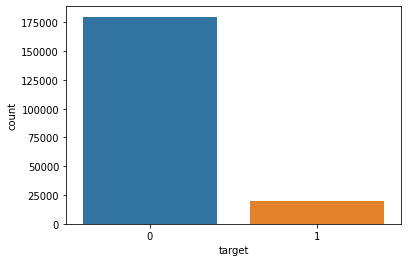

In [15]:
# Количество "одобренных" транзакций составляет примерно 10%

sns.countplot(train['target'])

train["target"].value_counts() / train.shape[0] * 100

<AxesSubplot:>

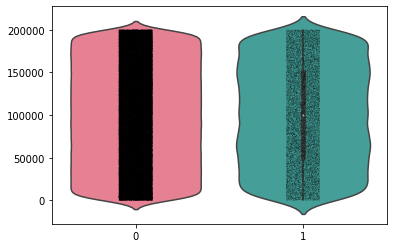

In [16]:
# Судя по всему, так как 0 и 1 распределены равномерно по оси индексов, то данные были подготовлены искусственно.
# А также искать зависимость target от индекса не имеет смысла

sns.violinplot(x=train.target.values, y=train.index.values, palette="husl")
sns.stripplot(x=train.target.values, y=train.index.values,
              jitter=True, color="black", size=0.5, alpha=0.5)

In [17]:
# Считаем корреляцию между значенями

corr_train = train[train.columns.values[2:]].corr().values.flatten()
corr_train = corr_train[corr_train != 1]

corr_test = test.corr().values.flatten()
corr_test = corr_test[corr_test != 1]

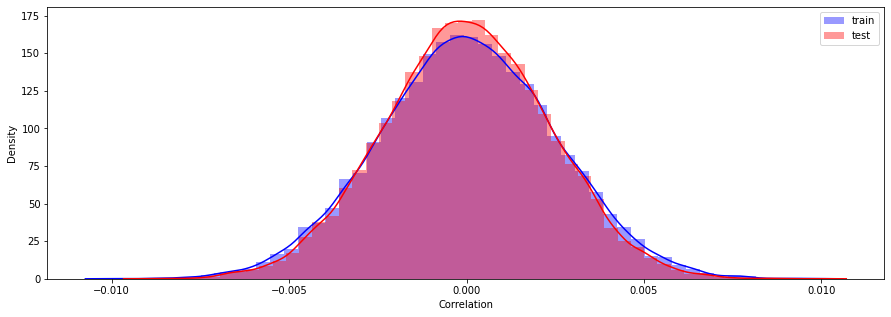

In [18]:
# Как видно, корреляция между признаками довольно низкая, что может говорить об искусственной декорелляции
# (Ведь данные анонимизированы)

plt.figure(figsize=(15, 5))
sns.distplot(corr_train, color="Blue", label="train")
sns.distplot(corr_test, color="Red", label="test")
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.legend()

In [19]:
# Для того, чтобы определить некоторые признаки, дающие лучший вклад в целевую переменную, попробуем использовать
# случайный лес

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

forest = RandomForestClassifier(max_depth=15, min_samples_leaf=25, n_estimators=15)
forest.fit(train.drop("target", axis=1).values, train.target.values)

RandomForestClassifier(max_depth=15, min_samples_leaf=25, n_estimators=15)

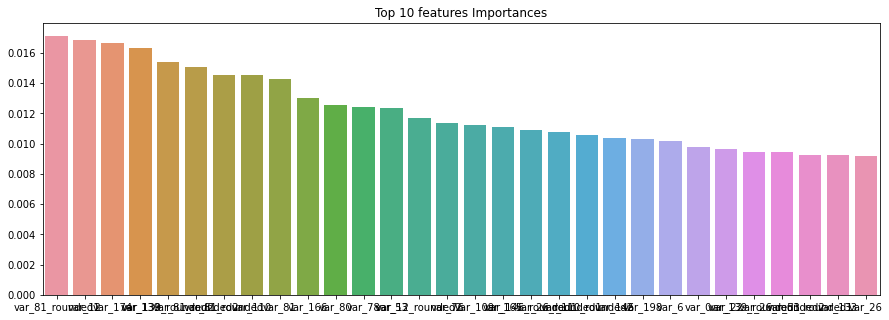

In [30]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1][0:30]
feature_names = train.drop("target", axis=1).columns.values

plt.figure(figsize=(15, 5))
sns.barplot(x=feature_names[indices], y=importances[indices]);
plt.title("Top 10 features Importances");

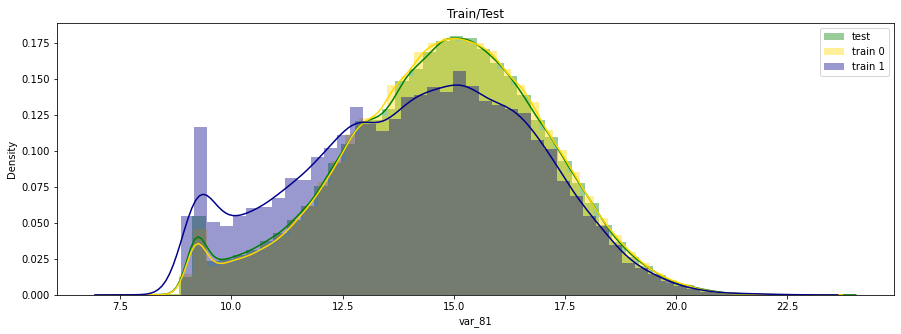

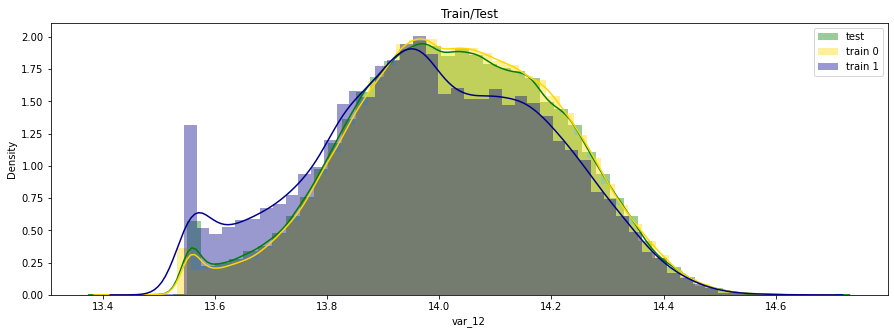

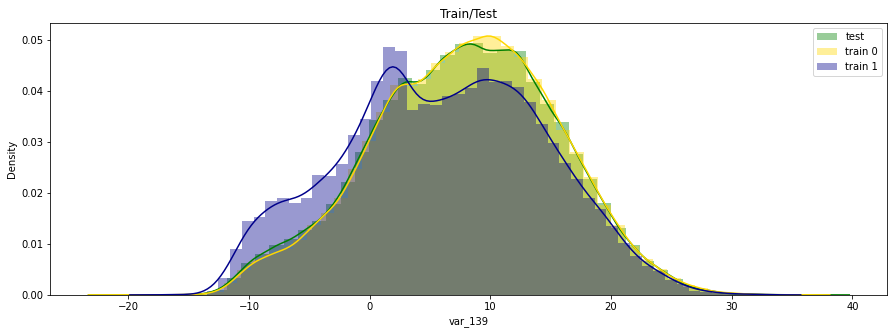

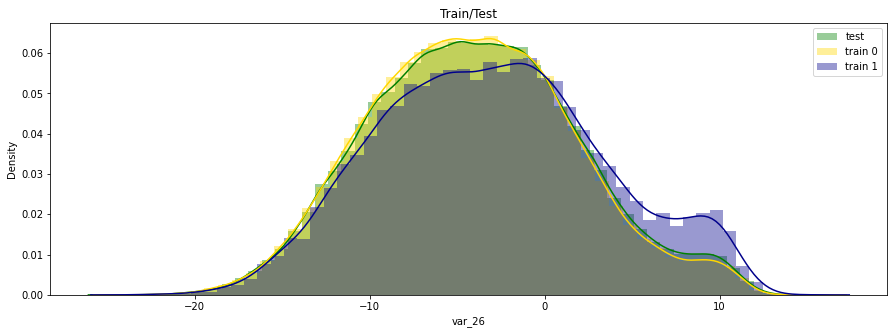

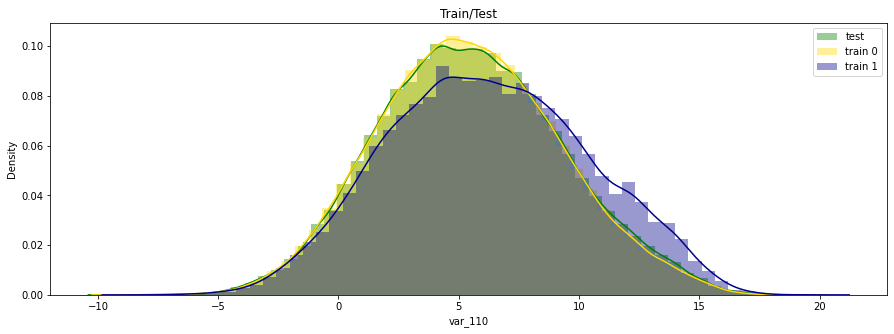

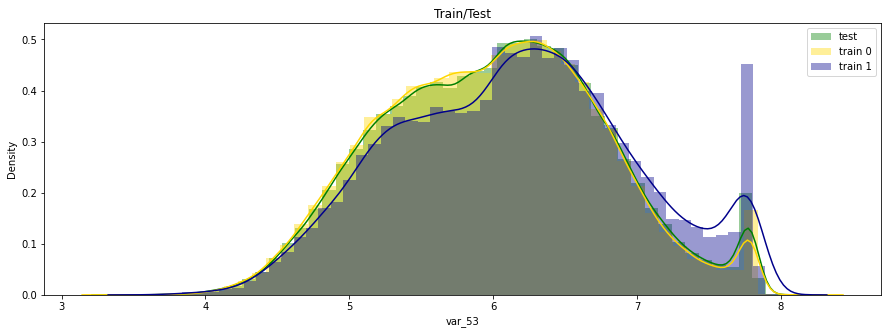

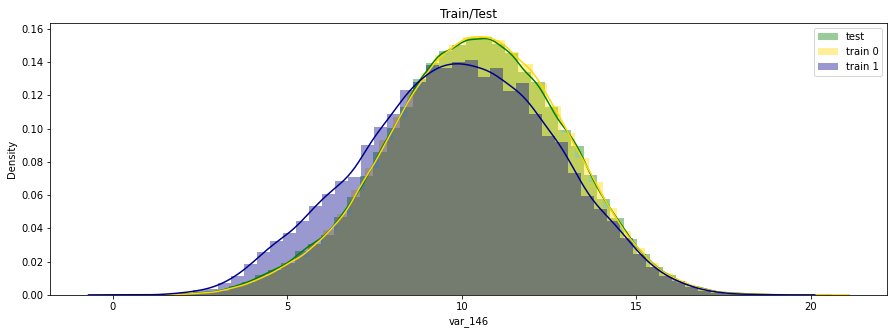

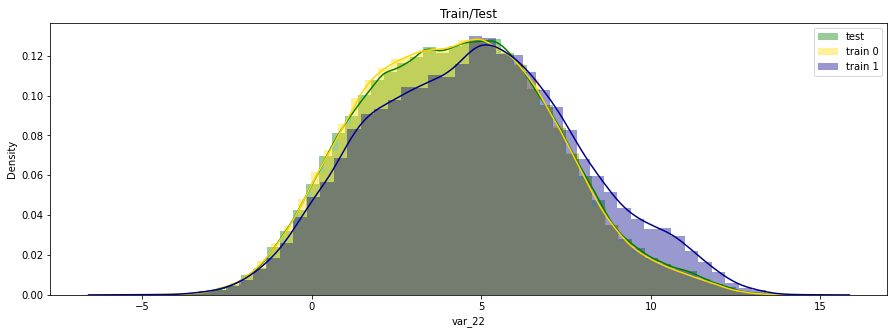

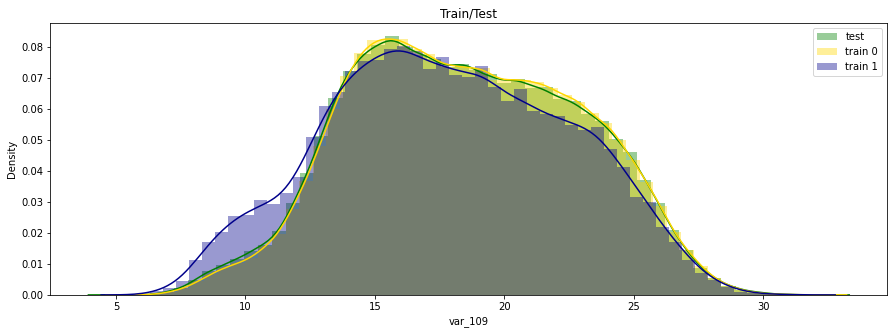

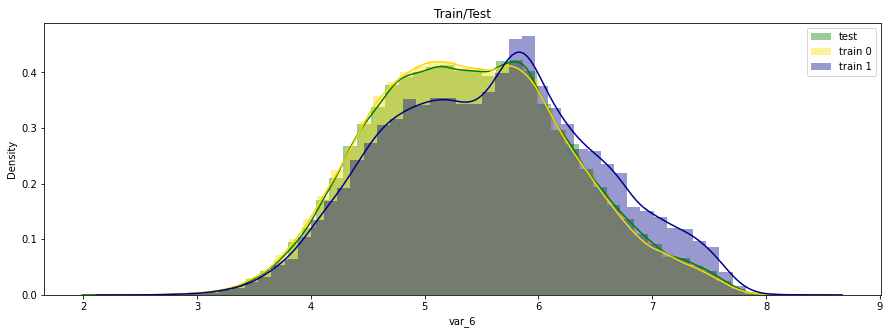

In [21]:
for n in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    
    name = feature_names[indices][n]
    
    sns.distplot(test.loc[:, name], ax=ax, color="green", label="test")
    sns.distplot(train.loc[train.target==0, name], ax=ax, color="gold", label="train 0")
    sns.distplot(train.loc[train.target==1, name], ax=ax, color="darkblue", label="train 1")
    
    ax.set_title("Train/Test")
    ax.set_xlabel(name)
    ax.legend()

Плотность в тестовом наборе меньше, чем в тренировочном, кроме того в некоторых распределениях наблюдаются пики, что говорит о большем количестве "единиц", соответствующих данным значениям переменных.

In [22]:
top_features = train.loc[:, feature_names[indices]]
top_features.describe()

,var_81,var_12,var_139,var_26,var_110,var_53,var_146,var_22,var_109,var_6
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,14.719024,14.023978,7.760193,-4.055133,5.513238,6.008569,10.341178,4.305430,18.458001,5.408949
std,2.299567,0.190059,7.686433,5.922210,3.823253,0.764753,2.518883,2.847958,4.355031,0.866607
min,7.586500,13.434600,-21.274300,-24.243100,-9.239800,3.344900,0.427400,-5.322500,5.769700,2.347300
25%,13.214775,13.894000,2.387575,-8.321725,2.817475,5.435600,8.646900,2.182400,15.107175,4.767700
50%,14.844500,14.025500,8.066250,-4.196900,5.394300,6.027800,10.395600,4.275150,18.281350,5.385100
75%,16.340800,14.164200,13.232525,-0.090200,8.104325,6.542900,12.113225,6.293200,21.852900,6.003000
max,23.132400,14.654500,36.097100,15.675100,19.519300,8.231500,20.437300,14.594500,32.059100,8.447700


In [23]:
# Добавим несколько новых признаков путём округления данных до разного знака

features = []
for column in top_features.columns:
    if column != "ID_code" and column != "target":
        features.append(column)

for feature in features:
    train[feature + "_rounded"] = np.round(train.loc[:, feature].values)
    train[feature + "_rounded1"] = np.round(train.loc[:, feature].values, 1)
    train[feature + "_rounded2"] = np.round(train.loc[:, feature].values, 2)
    
    test[feature + "_rounded"] = np.round(test.loc[:, feature].values)
    test[feature + "_rounded1"] = np.round(test.loc[:, feature].values, 1)
    test[feature + "_rounded2"] = np.round(test.loc[:, feature].values, 2)

In [24]:
train.shape, test.shape

((200000, 231), (200000, 231))

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

forest = RandomForestClassifier(max_depth=15, min_samples_leaf=25, n_estimators=15)
forest.fit(train.drop("target", axis=1).values, train.target.values)

RandomForestClassifier(max_depth=15, min_samples_leaf=25, n_estimators=15)

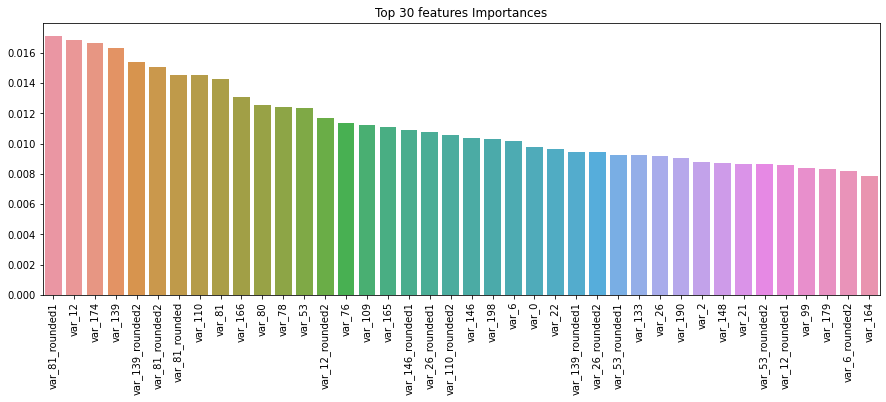

In [26]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1][0:40]
feature_names = train.drop("target", axis=1).columns.values

plt.figure(figsize=(15, 5))
sns.barplot(x=feature_names[indices], y=importances[indices]);
plt.title("Top 30 features Importances");
plt.xticks(rotation=90);

Как видно, некоторые искусственные признаки оказались довольно неплохими

In [28]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

# Используем градиентный бустинг для нашей модели

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.3,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 8.0,
    'num_leaves': 10,
    'num_threads': 12,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

out_of_fold = np.zeros(len(train))

n = 1000000
folds = StratifiedKFold(n_splits=10, shuffle=True)

for fold, (train_i, validation_i) in enumerate(folds.split(train.values, target.values)):
    train_data = lgb.Dataset(train.iloc[train_i][features], label=target.iloc[train_i])
    validation_data = lgb.Dataset(train.iloc[validation_i][features], label=target.iloc[validation_i])

    clf = lgb.train(param, train_data, n, valid_sets = [train_data, validation_data],
                    verbose_eval=1000, early_stopping_rounds = 2000)
    
    out_of_fold[validation_i] = clf.predict(train.iloc[validation_i][features], num_iteration=clf.best_iteration)

print("Cross val score: {}".format(roc_auc_score(target, out_of_fold)))

[LightGBM] [Info] Number of positive: 18089, number of negative: 161911
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 55173
[LightGBM] [Info] Number of data points in the train set: 180000, number of used features: 230
Training until validation scores don't improve for 2000 rounds
[1000]	training's auc: 0.864403	valid_1's auc: 0.857649
[2000]	training's auc: 0.893448	valid_1's auc: 0.883462
[3000]	training's auc: 0.906454	valid_1's auc: 0.893429
[4000]	training's auc: 0.914385	valid_1's auc: 0.898174
[5000]	training's auc: 0.919957	valid_1's auc: 0.900715
[6000]	training's auc: 0.924502	valid_1's auc: 0.902513
[7000]	training's auc: 0.928426	valid_1's auc: 0.903356
[8000]	training's auc: 0.931871	valid_1's auc: 0.904004
[9000]	training's auc: 0.935067	valid_1's auc: 0.904176
[10000]	training's auc: 0.938111	valid_1's auc: 0.904248
[11000]	t

Training until validation scores don't improve for 2000 rounds
[1000]	training's auc: 0.864987	valid_1's auc: 0.856253
[2000]	training's auc: 0.893984	valid_1's auc: 0.881624
[3000]	training's auc: 0.906829	valid_1's auc: 0.89154
[4000]	training's auc: 0.914623	valid_1's auc: 0.896354
[5000]	training's auc: 0.92008	valid_1's auc: 0.898829
[6000]	training's auc: 0.924653	valid_1's auc: 0.900199
[7000]	training's auc: 0.928577	valid_1's auc: 0.901195
[8000]	training's auc: 0.932091	valid_1's auc: 0.901693
[9000]	training's auc: 0.935354	valid_1's auc: 0.902148
[10000]	training's auc: 0.938412	valid_1's auc: 0.902654
[11000]	training's auc: 0.941285	valid_1's auc: 0.902721
[12000]	training's auc: 0.944037	valid_1's auc: 0.902578
[13000]	training's auc: 0.94672	valid_1's auc: 0.902859
[14000]	training's auc: 0.949289	valid_1's auc: 0.902932
[15000]	training's auc: 0.951748	valid_1's auc: 0.903074
[16000]	training's auc: 0.95412	valid_1's auc: 0.903046
Early stopping, best iteration is:
[14

Результат посылки на kaggle:
![Alt text](submission_result.png?raw=true "Title")